# Social choice, Final project, part 2 

In [2]:
import time
import numpy as np
import networkx as nx
from collections import OrderedDict
from operator import itemgetter
import ast

## Additional supportive functions: (utils)

In [3]:
def build_R_matrix(data:list ,candidates:set):
	"""
	:: matrix R is a matrix which each entry [p][q] represents
	:: the number of violations that will occur if p is ranked ahead of q in the final ranking
	"""
	R = np.zeros(shape=(len(candidates),)*2)
	for p in range(len(candidates)):
		for q in range(len(candidates)):
			if p==q:
				continue
			sum=0
			for vote in data:
				try:
					if vote.index(p+1)>vote.index(q+1):
						sum +=1
				except:
					pass
			R[p][q] = sum
	return R

In [4]:
def calc_lower_bound_on_consensus_ranking(R, P):
	"""
	:: calculates the lower bound of the consensus ranking by the last element in (6) at the article
	"""
	sum=0
	for p in P:
		p -= 1
		for q in P:
			if p==q:
				continue
			q -= 1
			sum += min(R[p][q],R[q][p])
	return 0.5*sum

In [5]:
def calc_consensus_ranking(R,ranking):
	"""
	:: calculates the consensus ranking by (4) at the article
	"""
	sum=0
	for i,p in enumerate(ranking):
		p -= 1
		for j,q in enumerate(ranking):
			if j<=i:
				continue
			q -= 1
			sum += R[p][q]
	return sum

In [6]:
def build_attr(R,T,B,P,M=None,MR=None):
	"""
	:: builds attributes for the new node in the graph
	"""
	attr = {
		'T': T,
		'B': B,
		'M': ('?,' * (len(R) - len(T) - len(B)))[:-1] if M==None else M,
		'MR': MR,
		'P' : P,
		'active': True
	}
	return attr

In [7]:
def probing_heuristic(R,P):
	"""
	:: Implementation of probing heuristic algorithm which can be found in the article (page 11)
	"""
	M = []
	P = P.copy()
	while len(P)>1:
		minKey = 10**5
		minVal = 10**5
		for p in P:
			calc1 = sum([R[p-1][q-1] for q in P if p is not q])
			calc2 = sum([R[q-1][p-1] for q in P if p is not q])
			val = calc1/(calc1+calc2) if calc1+calc2!=0 else 0
			if val<minVal:
				minVal=val
				minKey=p
			elif val==minVal:
				if p<minKey:
					minKey=p
		M.append(minKey)
		if minKey in P:
			P.remove(minKey)
	for p in P:
		M.append(p)
	return M

In [8]:
def branch_and_bound(G):
	"""
	:: selects a node to branch from him
	"""
	minVal=10**5
	minNode = None
	for name,node in G._node.items():
		if node['active']:
			val = node['MR']
			if val<minVal:
				minVal = val
				minNode = name
			elif val==minVal: # in case of ties select the node with the longest partial ranking
				if G._node[minNode]['M']>node['M']:
					minVal = val
					minNode = name
	return minNode

In [9]:
def find_dominant_candidates(P,T):
	"""
	:: appends to T the dominant proposals
	"""
	found_dominant = True
	while found_dominant:
		found_dominant = False
		to_be_removed = set()
		for candidate in P:
			candidate -= 1
			flag = True
			for p in P:
				p -= 1
				if candidate==p:
					continue
				if R[candidate][p] > R[p][candidate]:
					flag = False
			if flag:
				found_dominant = True
				T.append(candidate+1)
				to_be_removed.add(candidate+1)

		for candidate in to_be_removed:
			P.remove(candidate)

In [10]:
def find_dominated_candidates(P,B):
	"""
	:: inserts dominated candidates into B
	"""
	found_dominated = True
	while found_dominated:
		found_dominated = False
		to_be_removed = set()
		for candidate in P:
			candidate -= 1
			flag = True
			for p in P:
				p -= 1
				if candidate == p:
					continue
				if R[candidate][p] < R[p][candidate]:
					flag = False
			if flag:
				found_dominated = True
				B.insert(0,candidate+1)
				to_be_removed.add(candidate+1)
		for candidate in to_be_removed:
			P.remove(candidate)

In [11]:
def update_lower_bound(R,all_proposals,T,B,P):
	"""
	:: calculates the new lower bound based on the parent's lower bound
	"""
	T_ = [i for i in T if i in all_proposals]
	B_ = [i for i in B if i in all_proposals]
	sum = 0
	while len(T_):
		p=T_.pop(0)
		for q in T_+list(P)+B_:
			sum += R[p-1][q-1]
	while len(B_):
		p = B_.pop()
		for q in list(P)+B_:
			sum += R[q-1][p-1]
	return calc_lower_bound_on_consensus_ranking(R, list(P)) + sum

In [12]:
def update_consensus_rankning(R, all_proposals, T, B, P):
	"""
	:: calculates the new consensus ranking value based on the parent's value
	"""
	T_ = [i for i in T if i in all_proposals]
	B_ = [i for i in B if i in all_proposals]
	sum = 0
	while len(T_):
		p = T_.pop(0)
		for q in T_ + list(P) + B_:
			sum += R[p - 1][q - 1]
	while len(B_):
		p = B_.pop()
		for q in list(P) + B_:
			sum += R[q - 1][p - 1]
	return calc_consensus_ranking(R, list(P)) + sum

In [13]:
def optimal_consensus_ranking(R,P):
	"""
	:: Implementation of the main algorithm in the article , page 12-13.
	"""
	T = []
	B = []

	find_dominant_candidates(P,T)
	find_dominated_candidates(P,B)

	node_name = 0
	G = nx.DiGraph()
	missing_rankning_group = P.copy()

	attr = build_attr(R,T,B,P,MR=calc_lower_bound_on_consensus_ranking(R,P))
	G.add_node(node_name,**attr)
	node_name += 1
	M = probing_heuristic(R,P)
	curr_lower_bound = G._node[0]['MR']
	curr_upper_bound = calc_consensus_ranking(R,M)
	curr_best_ranking = ','.join([str(obj) for obj in T])+','+M+','.join([str(obj) for obj in B])+',' if type(M)==str else\
		','.join([str(obj) for obj in T])+','+','.join([str(obj) for obj in M])+','+','.join([str(obj) for obj in B])

	if curr_upper_bound == curr_lower_bound:
		curr_best_ranking = curr_best_ranking.replace(',,', ',')
		if curr_best_ranking[-1]==',':
			curr_best_ranking=curr_best_ranking[:-1]
		if curr_best_ranking[0]==',':
			curr_best_ranking=curr_best_ranking[1:]
		curr_best_ranking = ast.literal_eval('['+curr_best_ranking+']')
		return curr_best_ranking

	selected_node = branch_and_bound(G)
	while selected_node is not None:
		G._node[selected_node]['active']=False
		if G._node[selected_node]['MR'] > curr_upper_bound: # should be "If the lower bound of the root node equals this upper bound go to Step 3."
			selected_node = branch_and_bound(G)
			continue

		unknown_ranking = all_candidates - set([i for i in G._node[selected_node]['T']+G._node[selected_node]['B']])
		for p in unknown_ranking:
			B_ = G._node[selected_node]['B'].copy()
			T_ = G._node[selected_node]['T'].copy()
			T_.append(p)
			P_ = G._node[selected_node]['P'].copy()
			P_.remove(p)
			find_dominant_candidates(P_,T_)
			find_dominated_candidates(P_,B_)
			attr = build_attr(R, T_, B_, P_, MR=update_lower_bound(R,missing_rankning_group,T_,B_,P_))
			if attr['M']=='':
				if calc_consensus_ranking(R,[i for i in (T_+B_) if i in missing_rankning_group]) >= curr_lower_bound:
					continue
			if attr['MR'] > curr_lower_bound:
				continue

			G.add_node(node_name, **attr)
			G.add_edge(selected_node,node_name)
			node_name +=1
			M = probing_heuristic(R, P_)
			if update_consensus_rankning(R,missing_rankning_group,attr['T'],attr['B'],M) < curr_upper_bound:
				curr_upper_bound = update_consensus_rankning(R,missing_rankning_group,attr['T'],attr['B'],M)
				curr_best_ranking = ','.join([str(obj) for obj in attr['T']]) + ',' + M + ','.join(
					[str(obj) for obj in attr['B']]) + ',' if type(M) == str else \
					','.join([str(obj) for obj in attr['T']]) + ',' + ','.join([str(obj) for obj in M]) + ',' + ','.join(
						[str(obj) for obj in attr['B']])
				for node in G:
					if G._node[node]['active'] and G._node[node]['MR']>curr_upper_bound:
						G._node[node]['active'] = False

		selected_node = branch_and_bound(G)

	curr_best_ranking = curr_best_ranking.replace(',,', ',')
	if curr_best_ranking[-1] == ',':
		curr_best_ranking = curr_best_ranking[:-1]
	if curr_best_ranking[0] == ',':
		curr_best_ranking = curr_best_ranking[1:]

	curr_best_ranking = ast.literal_eval('['+curr_best_ranking+']')
	return curr_best_ranking

In [14]:
def constructTournamentGraph(alternatives, votings):
    """
    :: Construction of a tournament graph, necessary for the implementation of Copeland
    """

    edgesDict = {}
    actualEdges = []
    voteLength = len(votings[0])
    for vote in votings:
        for i in range(voteLength - 1):
            for j in range(i + 1, voteLength):
                edge = (vote[i], vote[j])
                reversedEdge = (vote[j], vote[i])
                if edge not in edgesDict.keys() and reversedEdge not in edgesDict.keys():
                    edgesDict[edge] = -1
                else:
                    if edge in edgesDict.keys():
                        edgesDict[edge] -= 1
                    else:
                        edgesDict[reversedEdge] += 1

    for key, val in edgesDict.items():
        if val > 0:
            actualEdges.append(key)
        elif val < 0:
            a, b = key
            actualEdges.append((b, a))
        else:
            a, b = key
            if alternatives[a] < alternatives[b]:
                actualEdges.append((b, a))
            else:
                actualEdges.append(key)

    G = nx.DiGraph()
    for edge in actualEdges:
        G.add_edge(edge[0], edge[1])

    alternativesKeyDict = {}
    for idx, alternative in enumerate(alternatives.keys()):
        alternativesKeyDict[idx] = alternative

    tournamentMat = np.zeros(shape=(len(alternatives.keys()),) * 2)
    for row in range(len(tournamentMat)):
        for col in range(len(tournamentMat[0])):
            if G.has_edge(alternativesKeyDict[col], alternativesKeyDict[row]):
                tournamentMat[row][col] = (1 / G.out_degree(alternativesKeyDict[col]))

    D = np.ones(shape=(len(alternatives.keys()),) * 2) * (1 / len(alternatives.keys()))
    return tournamentMat, D, G

In [15]:
def Copeland(G):
    """
    :: Implementation of Copeland voting rule
    """
    winners, scores = [], {}
    max_out = 0
    for node in G.nodes():
        curr_out = G.in_degree(node)
        scores[node] = curr_out
        if curr_out > max_out:
            max_out = curr_out
            winners = [node]
        elif curr_out == max_out:
            winners.append(node)
    return OrderedDict(sorted(scores.items(), key=itemgetter(1), reverse=True))

In [16]:
def calc_MR(vote_matrix, agg_rankings):
	"""
	:: given a voting matrix and a ranking list we'll output the M(R) measure for the ranking list, as calculated in the paper
	"""
	def pairwise_list(rankings):
		p_over_q = []
		for i in range(len(rankings)):
			for j in range(i + 1, len(rankings)):
				p_over_q.append((rankings[i], rankings[j]))
		return p_over_q
	agg_ranking_pairs = pairwise_list(agg_rankings)
	#print(f"these are the pairs: {agg_ranking_pairs}")
	MR = 0
	for row in vote_matrix:
		curr_pairwise = pairwise_list(row)
		for pair in curr_pairwise:
			MR += 0 if pair in agg_ranking_pairs else 1
	return MR


## Running & getting results

In [17]:
"""
:: data format should be a dictionary where voters are the keys and their votes are the values.
:: The votes format is a list that left proposal is preferred over the right one.
:: The proposals MUST start at 1 (till N) with jumps of 1! 
"""

# constructing the datasets
sigmas = [1, 4, 9]
proposal_nums = [20, 20, 30, 40, 100]
reviewers_num = [50, 60, 76, 72, 76]
config_times = {}
MR = {}
max_times = {}
alternatives = {x: x for x in range(150)}  # just a technicality for a copeland function
for i in range(len(proposal_nums)):
    objective_grade = sorted(np.random.normal(75, 10, proposal_nums[i]), reverse=True)
    
    for sigma in sigmas:
        config_times[(proposal_nums[i], reviewers_num[i], sigma, 'copeland')] = 0
        config_times[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] = 0
        MR[(proposal_nums[i], reviewers_num[i], sigma, 'copeland')] = 0
        MR[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] = 0
        max_times[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] = 0
        print(f"current configs that are running: {proposal_nums[i], reviewers_num[i], sigma}")
        for epoch in range(25):
            curr_data = {}
            curr_votes = []  # for copeland
            for j in range(reviewers_num[i]):
                curr_rev_props = np.random.choice(range(1, proposal_nums[i]+1), 4, replace=False)
                curr_rev_grades = []
                for x in curr_rev_props:
                    curr_rev_grades.append((x, objective_grade[x - 1] + np.random.normal(0, sigma)))
                curr_rev_ranks = [y[0] for y in sorted(curr_rev_grades, key=lambda x: x[1], reverse=True)]
                curr_data[j] = curr_rev_ranks
                curr_votes.append(curr_rev_ranks)
                
            curr_votes = np.array(curr_votes).astype('int')
            votes = [val for key, val in curr_data.items()]
            all_candidates = set(range(1, proposal_nums[i] + 1))
            
            # applying Copeland
            cope_start = time.time()
            M, D, G = constructTournamentGraph(alternatives, curr_votes)
            copeland_res = [key for key, val in Copeland(G).items()]
            config_times[(proposal_nums[i], reviewers_num[i], sigma, 'copeland')] = time.time() - cope_start
            
            # applying B&B
            bnb_start = time.time()
            R = build_R_matrix(votes, all_candidates)
            algo_rankings = optimal_consensus_ranking(R, all_candidates)
            config_times[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] += time.time() - bnb_start
            if (time.time()-bnb_start) > max_times[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')]:
                max_times[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] = time.time()-bnb_start
            MR[(proposal_nums[i], reviewers_num[i], sigma, 'copeland')] += calc_MR(curr_votes, copeland_res)
            MR[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] += calc_MR(curr_votes, algo_rankings)
            
        config_times[(proposal_nums[i], reviewers_num[i], sigma, 'copeland')] /= 25
        config_times[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] /= 25
        MR[(proposal_nums[i], reviewers_num[i], sigma, 'copeland')] /= 25
        MR[(proposal_nums[i], reviewers_num[i], sigma, 'bnb')] /= 25

current configs that are running: (20, 50, 1)
current configs that are running: (20, 50, 4)
current configs that are running: (20, 50, 9)
current configs that are running: (20, 60, 1)
current configs that are running: (20, 60, 4)
current configs that are running: (20, 60, 9)
current configs that are running: (30, 76, 1)
current configs that are running: (30, 76, 4)
current configs that are running: (30, 76, 9)
current configs that are running: (40, 72, 1)
current configs that are running: (40, 72, 4)
current configs that are running: (40, 72, 9)
current configs that are running: (100, 76, 1)
current configs that are running: (100, 76, 4)
current configs that are running: (100, 76, 9)


In [18]:
"""
:: Optional to run, these are just dictionaries with the results
"""
print("Times:\n", config_times)
print("MR values:\n", MR)
#print("Max times for the B&B algorithm:\n", max_times)

Times:
 {(20, 50, 1, 'copeland'): 0.0003199577331542969, (20, 50, 1, 'bnb'): 0.019519462585449218, (20, 50, 4, 'copeland'): 0.0003618431091308594, (20, 50, 4, 'bnb'): 0.025122032165527344, (20, 50, 9, 'copeland'): 0.0003613758087158203, (20, 50, 9, 'bnb'): 0.030245389938354492, (20, 60, 1, 'copeland'): 0.00035994529724121094, (20, 60, 1, 'bnb'): 0.02344093322753906, (20, 60, 4, 'copeland'): 0.0004799938201904297, (20, 60, 4, 'bnb'): 0.03479811668395996, (20, 60, 9, 'copeland'): 0.00047984123229980467, (20, 60, 9, 'bnb'): 0.04823720932006836, (30, 76, 1, 'copeland'): 0.00047994613647460937, (30, 76, 1, 'bnb'): 0.09712224006652832, (30, 76, 4, 'copeland'): 0.0005599498748779297, (30, 76, 4, 'bnb'): 0.1401587200164795, (30, 76, 9, 'copeland'): 0.0004799365997314453, (30, 76, 9, 'bnb'): 0.149236478805542, (40, 72, 1, 'copeland'): 0.00047994613647460937, (40, 72, 1, 'bnb'): 0.14695950508117675, (40, 72, 4, 'copeland'): 0.0004799175262451172, (40, 72, 4, 'bnb'): 0.22952234268188476, (40, 72,

## Comparison & Graphs

In [19]:
cope_times, bnb_times, cope_MRs, bnb_MRs = [], [], [], []
for key in config_times:
    if key[3] == 'bnb':
        bnb_times.append(config_times[key])
        bnb_MRs.append(MR[key])
    else:
        cope_times.append(config_times[key])
        cope_MRs.append(MR[key])
configs = [x[:3] for y, x in enumerate(list(config_times.keys())) if y%2 == 0]

time_ratio = [bnb_times[i]/cope_times[i] for i in range(len(bnb_times))]
MR_ratio = [bnb_MRs[i]/cope_MRs[i] for i in range(len(bnb_MRs))]

In [20]:
plt.clf()
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bnb_MRs, width, label='Branch&Bound')
rects2 = ax.bar(x + width/2, cope_MRs, width, label='Copeland')

ax.set_ylabel('MR values')
ax.set_title('Copeland vs our algorithm MRs')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(configs, rotation = 'vertical')
ax.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import math

x = np.arange(len(configs))  
width = 0.2  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bnb_times, width, label='Branch&Bound')
rects2 = ax.bar(x + width/2, cope_times, width, label='Copeland')

ax.set_ylabel('Times')
ax.set_title('Copeland vs our algorithm times')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(configs, rotation = 'vertical')
ax.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

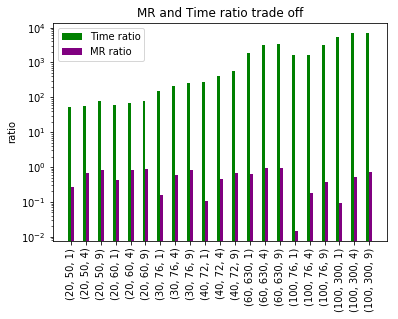

In [25]:
plt.clf()
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, time_ratio, width, label='Time ratio', color = 'green')
rects2 = ax.bar(x + width/2, MR_ratio, width, label='MR ratio', color = 'purple')

ax.set_ylabel('ratio')
ax.set_title('MR and Time ratio trade off')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(configs, rotation = 'vertical')
ax.legend()
plt.show()